In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

In [17]:
train_dir = 'chest/train'
val_dir = 'chest/val'
test_dir = 'chest/test'

# Buat image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
model = Sequential([
    # Layer Konvolusi pertama
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    # Layer Konvolusi kedua
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Layer Konvolusi ketiga untuk fitur yang lebih kompleks
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Layer Konvolusi keempat
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Meratakan output dari layer konvolusi
    Flatten(),

    # Menambahkan Dropout untuk mencegah overfitting
    Dropout(0.5),

    # Layer Dense
    Dense(512, activation='relu'),

    # Layer output dengan aktivasi sigmoid untuk klasifikasi biner
    Dense(1, activation='sigmoid')
])


model.summary()

d:\project ngoding\fullstack pneumonia app detect\model\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Mengompilasi model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

print(f"Gambar training ditemukan: {train_generator.samples}")
print(f"Gambar validasi ditemukan: {validation_generator.samples}")


# 2. Definisikan Learning Rate Scheduler
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3,     
    verbose=1, 
    factor=0.5,          
    min_lr=0.00001     
)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    callbacks=[learning_rate_reduction]
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Gambar training ditemukan: 5216
Gambar validasi ditemukan: 16
Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 296ms/step - accuracy: 0.7456 - loss: 0.5341 - val_accuracy: 0.6250 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 291ms/step - accuracy: 0.7747 - loss: 0.4329 - val_accuracy: 0.8750 - val_loss: 0.4762 - learning_rate: 0.0010
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 48s 292ms/step - accuracy: 0.8324 - loss: 0.3733 - val_accuracy: 0.7500 - val_loss: 0.5991 - learning_rate: 0.0010
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 49s 299ms/step - accuracy: 0.8712 - loss: 0.2878 - val_accuracy: 0.8125 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.8952 - loss: 0.2464
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 284ms/step - accuracy: 0.8947 - loss: 0

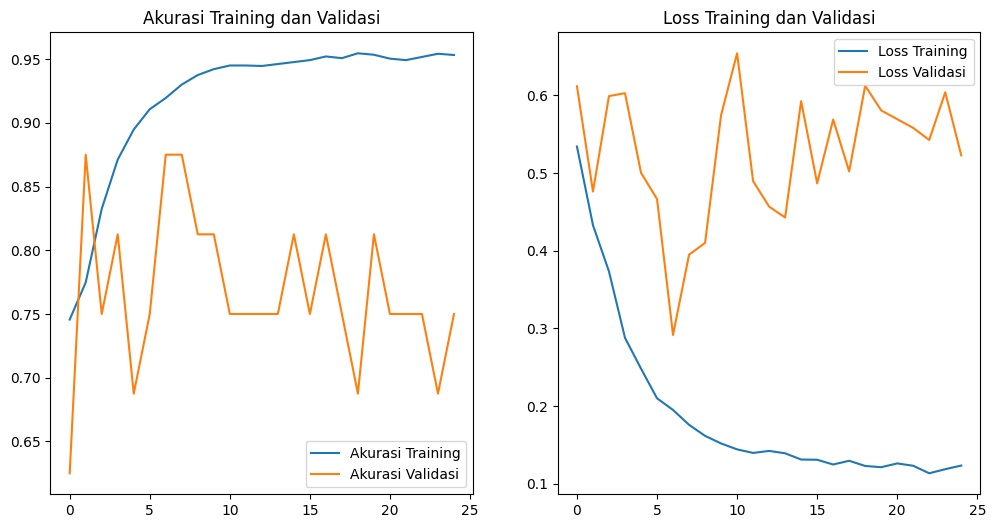

In [21]:
# nilai akurasi dan loss dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# plot untuk Akurasi
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Training')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Training dan Validasi')

# plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Training')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Training dan Validasi')
plt.show()

In [47]:
def predict_image(img_path):
    """Fungsi untuk memprediksi gambar tunggal."""

    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = x / 255.0

    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    
    print(f"File: {img_path}")
    print(f"Nilai Prediksi: {classes[0][0]}")
    
    if classes[0] > 0.5:
        print("Hasil: Terdeteksi PNEUMONIA")
    else:
        print("Hasil: NORMAL")


try:
    predict_image('chest/test/NORMAL/IM-0001-0001.jpeg')
    print("-" * 30)
    predict_image('chest/test/PNEUMONIA/person1_virus_6.jpeg')
except FileNotFoundError:
    print("\nPastikan path file gambar sudah benar!")
    print("Misalnya: 'chest/test/NORMAL/nama_file.jpeg'")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
File: chest/test/NORMAL/IM-0001-0001.jpeg
Nilai Prediksi: 0.6380175352096558
Hasil: Terdeteksi PNEUMONIA
------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
File: chest/test/PNEUMONIA/person1_virus_6.jpeg
Nilai Prediksi: 0.9999538660049438
Hasil: Terdeteksi PNEUMONIA
